<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.


In [17]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Consideraremos que cada secuencia para este dataset es una oración.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.


Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos las oraciones del dataset y ses explorará la cantidad de términos presentes.


In [1]:

import requests

url = "https://gist.githubusercontent.com/m-242/ecb3e130b76a3b12f7ef41b04f486405/raw/8a3e992841f55f33b9836631b62ac0250b5fe7f8/neuromancer.txt"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

text = response.text
# Now the 'text' variable contains the content of the novel.  You can use it in your model.
print(f"Downloaded {len(text)} characters.")


Downloaded 451934 characters.


In [44]:

# Preprocessing the text
import re

def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  # Remove special characters and numbers
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  # Replace multiple spaces with single space
  text = re.sub(r'\s+', ' ', text).strip()
  return text

processed_text = preprocess_text(text)

tokens = processed_text.split()

sequence_length = 20
segmented_sentences = []
for i in range(0, len(tokens) - sequence_length):
    seq = tokens[i:i + sequence_length]
    segmented_sentences.append(seq)

print(f"Number of sequences: {len(segmented_sentences)}")
print("Example sequence:", segmented_sentences[0])


Number of sequences: 79307
Example sequence: ['william', 'gibson', 'neuromancer', 'dedication', 'for', 'deb', 'who', 'made', 'it', 'possible', 'with', 'love', 'part', 'one', 'chiba', 'city', 'blues', 'the', 'sky', 'above']


In [45]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


###  Tokenizar

In [46]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [47]:
tokenized_sentences[0:5]

[[9370,
  9369,
  1162,
  3297,
  20,
  4791,
  105,
  141,
  10,
  1161,
  17,
  872,
  276,
  33,
  191,
  214,
  9363,
  1,
  333,
  192],
 [9369,
  1162,
  3297,
  20,
  4791,
  105,
  141,
  10,
  1161,
  17,
  872,
  276,
  33,
  191,
  214,
  9363,
  1,
  333,
  192,
  1],
 [1162,
  3297,
  20,
  4791,
  105,
  141,
  10,
  1161,
  17,
  872,
  276,
  33,
  191,
  214,
  9363,
  1,
  333,
  192,
  1,
  750],
 [3297,
  20,
  4791,
  105,
  141,
  10,
  1161,
  17,
  872,
  276,
  33,
  191,
  214,
  9363,
  1,
  333,
  192,
  1,
  750,
  11],
 [20,
  4791,
  105,
  141,
  10,
  1161,
  17,
  872,
  276,
  33,
  191,
  214,
  9363,
  1,
  333,
  192,
  1,
  750,
  11,
  1]]

### Organizando y estructurando el dataset

 **Data split**:En este punto tenemos en la variable `tokenized_sentences` los
versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [48]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

**Truncación por contexto**: Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [49]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (sequence_length+1):
    extra = len(sent)-(sequence_length+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+sequence_length+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [50]:
len(tok_sent)

63445

In [51]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=sequence_length+1, padding='pre'))


In [52]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [53]:
train_seqs.shape

(1205455, 21)

In [54]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:, :-1]
y = train_seqs[:, -1]

In [56]:
X[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  195,    1,
       1050,  182,    1,  253, 1991,  749,    4,  869,  458], dtype=int32)

In [57]:
y[0]

np.int32(1)

In [58]:
# Palabras del vocabulario
tok.index_word[5084]

'er'

In [59]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

9370

In [60]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'a': 3, 'and': 4, 'he': 5, 'to': 6, 'in': 7, 'his': 8, 'you': 9, 'it': 10, 'was': 11, 'case': 12, 'i': 13, 'said': 14, 'that': 15, 'her': 16, 'with': 17, 'on': 18, 'she': 19, 'for': 20, 'had': 21, 'as': 22, 'but': 23, 'from': 24, 'him': 25, 'at': 26, 'like': 27, 'up': 28, 'an': 29, 'were': 30, 'out': 31, 'into': 32, 'one': 33, 'its': 34, 'molly': 35, 'this': 36, 'back': 37, 'there': 38, 'what': 39, 'they': 40, 'is': 41, 'me': 42, 'no': 43, 'your': 44, 'now': 45, 'know': 46, 'hed': 47, 'we': 48, 'through': 49, 'got': 50, 'down': 51, 'all': 52, 'be': 53, 'eyes': 54, 'some': 55, 'then': 56, 'have': 57, 'when': 58, 'armitage': 59, 'man': 60, 'been': 61, 'here': 62, 'by': 63, 'get': 64, 'something': 65, 'black': 66, 'if': 67, 'so': 68, 'over': 69, 'white': 70, 'them': 71, 'just': 72, 'my': 73, 'maelcum': 74, 'not': 75, 'off': 76, 'across': 77, 'hand': 78, 'thing': 79, 'youre': 80, 'head': 81, 'do': 82, 'face': 83, 'against': 84, 'about': 85, 'way': 86, 'their': 87, 'dark

Case es el nombre del protagosnista

In [61]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'part': 664, 'chiba': 928, 'city': 829, 'one': 5012, 'sky': 554, 'above': 906, 'neuromancer': 163, 'the': 60195, 'blues': 17, 'it': 16455, 'dedication': 44, 'for': 8062, 'william': 1, 'gibson': 2, 'who': 1629, 'love': 201, 'deb': 26, 'made': 1288, 'with': 11884, 'possible': 170, 'port': 254, 'was': 17244, 'color': 320, 'of': 36497, 'television': 100, 'tuned': 40, 'to': 22647, 'a': 34149, 'dead': 1085, 'channel': 60, 'its': 4798, 'not': 2249, 'like': 6065, 'im': 1714, 'using': 160, 'case': 15019, 'heard': 580, 'someone': 462, 'say': 711, 'as': 6740, 'he': 22970, 'shouldered': 40, 'his': 17703, 'way': 2006, 'through': 3355, 'crowd': 475, 'around': 1846, 'door': 1545, 'chat': 140, 'my': 2283, 'bodys': 20, 'developed': 60, 'this': 4398, 'massive': 80, 'drug': 200, 'defi': 20, 'ciency': 20, 'sprawl': 487, 'voice': 1301, 'and': 28535, 'joke': 80, 'chatsubo': 60, 'bar': 440, 'professional': 60, 'expatriates': 20, 'you': 16071, 'could': 1644, 'drink': 200, 'there': 


### Definir el modelo

In [62]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1,
                    output_dim=50,
                    input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 50)         │       468,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9371)           │       309,243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 842,337 (3.21 MB)

 Trainable params: 842,337 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [63]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=sequence_length, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

In [64]:
class PerplexityCallback(keras.callbacks.Callback):
    def __init__(self, validation_data=None):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log training perplexity
        train_loss = logs.get('loss')
        if train_loss is not None:
            train_perplexity = np.exp(train_loss)
            print(f'\nTraining Perplexity: {train_perplexity:.4f}')
            logs['perplexity'] = train_perplexity

        # Calculate validation perplexity if validation data exists
        if self.validation_data is not None:
            val_loss = logs.get('val_loss')
            if val_loss is not None:
                val_perplexity = np.exp(val_loss)
                print(f'Validation Perplexity: {val_perplexity:.4f}')
                logs['val_perplexity'] = val_perplexity


### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=20, callbacks=[PerplexityCallback(tokenized_sentences_val)],  batch_size=500)

Epoch 1/20
2407/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3490 - loss: 3.1773
Training Perplexity: 23.1893
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.3490 - loss: 3.1772 - perplexity: 23.1893
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3635 - loss: 3.0869
Training Perplexity: 22.0352
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.3635 - loss: 3.0869 - perplexity: 22.0352
Epoch 3/20
2408/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3702 - loss: 3.0388
Training Perplexity: 20.8824
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.3702 - loss: 3.0388 - perplexity: 20.8824
Epoch 4/20
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3780 - loss: 2.9905
Training Perplexity: 19.8397
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.3780 - loss: 2.9905 - perplexity: 19.8397
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3871 - loss: 2.9358
Training Perplexity: 18.8792
2411/2

In [70]:
model.save('my_model.keras')


In [75]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/my_model.keras')

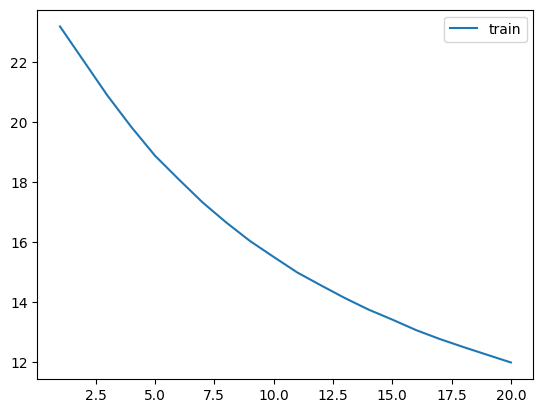

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['perplexity']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['perplexity'], label='train')
#sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

tuve que correr el modelo en dos partes porque la primera colapso la RAM


### Predicción de próxima palabra

In [77]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [78]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00


In [80]:
import gradio as gr

def model_response(human_text, model):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=sequence_length, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=lambda x: model_response(x, model),
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://452ac8565a3464081e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://452ac8565a3464081e.gradio.live


### Generación de secuencias

In [81]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

Molly es el nombre de la heroina de la novela

In [86]:
input_text='Molly'

generate_seq(model, tok, input_text, max_length=sequence_length, n_words=13)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'Molly said and drew up by the music of the shadows and sailed the'

###  Beam search y muestreo aleatorio

In [87]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=sequence_length):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [88]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input, temp=1):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp=temp)

    return history_tokens

Wintermute es el nombre de la IA que es central en la trama

In [92]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=5,input='Wintermute', temp=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [93]:
# veamos las salidas
for i in range(10):
    print(decode(salidas[i]))

['wintermute took havin tended agement abandoned']
['wintermute youll rattled paradise hallucination shiny']
['wintermute the doubt odd micrograms nonlethal']
['wintermute youll armitage jumps slid feel']
['wintermute the doubt odd micrograms curling']
['wintermute youll rattled paradise hallucination stilts']
['wintermute youll rattled grasp insurance pyramid']
['wintermute youll armitage jumps hoursyour spoke']
['wintermute youll armitage jumps slid pentagon']
['wintermute youll armitage jumps slid lows']
